# Causal Impact Analysis: Steve Madden Credit Booster

**Measuring the incremental effect on originated loans**

BNPL Analytics Team

---

## Executive Summary

This analysis measures the causal impact of the **Steve Madden Credit Booster** ($1,000 increase) on the number of originated loans. The Credit Booster ran from **September 8, 2025** to **November 18, 2025**.

**Key Question:** Did the credit booster result in incremental loans that would not have occurred otherwise?

**Methodology:** We use the CausalImpact package, which implements Bayesian structural time-series models to estimate the counterfactual (what would have happened without the intervention) using control merchants as predictors.


# 1. Setup and Configuration

## 1.1 Load Required Packages


In [1]:
# Install and load required packages
packages <- c(
  "CausalImpact",  # Causal inference
  "bigrquery",     # BigQuery connection
  "DBI",           # Database interface
  "dplyr",         # Data manipulation
  "tidyr",         # Data tidying
  "lubridate",     # Date handling
  "ggplot2",       # Visualization
  "zoo",           # Time series
  "corrplot",      # Correlation plots
  "scales"         # Scale formatting
)

# Install missing packages
new_packages <- packages[!(packages %in% installed.packages()[, "Package"])]
if (length(new_packages) > 0) {
  install.packages(new_packages, repos = "https://cloud.r-project.org/")
}

# Load all packages
invisible(lapply(packages, library, character.only = TRUE))

# Load helper functions
source("utils/bigquery_helpers.R")

print("All packages loaded successfully!")


Installing packages into '/opt/homebrew/lib/R/4.5/site-library'
(as 'lib' is unspecified)

also installing the dependencies 'BoomSpikeSlab', 'xts', 'bsts', 'assertthat', 'Boom', 'brio', 'clock', 'nanoparquet', 'rapidjsonr'


Loading required package: bsts

Loading required package: BoomSpikeSlab

Loading required package: Boom


Attaching package: 'Boom'


The following object is masked from 'package:stats':

    rWishart



Attaching package: 'BoomSpikeSlab'


The following object is masked from 'package:stats':

    knots


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: xts


Attaching package: 'bsts'


The following object is masked from 'package:BoomSpikeSlab':

    SuggestBurn



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() func

[1] "All packages loaded successfully!"


In [25]:
source("utils/bigquery_helpers.R")

BigQuery helpers loaded successfully!



## 1.2 Analysis Parameters

Configure all analysis parameters in this cell. Modify as needed for different experiments.


In [79]:
# ============================================================================
# CONFIGURABLE PARAMETERS - Modify these as needed
# ============================================================================

# BigQuery Project ID
BQ_PROJECT_ID <- "apz-analytics-prod" 

# Treatment merchant
TREATMENT_MERCHANT_ID <- 4896  # Steve Madden (collapsed from holding_id = 9)
TREATMENT_NAME <- "Steve Madden"

# Intervention period
INTERVENTION_START <- as.Date("2025-09-08")
INTERVENTION_END <- as.Date("2025-11-18")

# Data period
DATA_START <- as.Date("2025-06-15")
DATA_END <- NULL  # NULL = current_date - 23 days

# ============================================================================
# MERCHANTS TO EXCLUDE FROM CONTROL (also received credit boosters)
# These 66 merchants received credit boosters between Sep 8 - Nov 19, 2025
# Including them would contaminate the control group
# ============================================================================
EXCLUDED_MERCHANTS <- c(
  10296, 4918, 33509, 9031, 4851, 4896, 2884, 11307, 5351, 5235, 
  5361, 2666, 5242, 10006, 5238, 8844, 1251, 2059, 5237, 10319, 
  5619, 5589, 5625, 1638, 8487, 1640, 1641, 1636, 1651, 5573, 
  1655, 1637, 1646, 1649, 1647, 5540, 1639, 1665, 1660, 1666, 
  1642, 2868, 1656, 1654, 1635, 5591, 1648, 1643, 1657, 8552, 
  1634, 1661, 1644, 1662, 1653, 1663, 7609, 4416, 1650, 7350, 
  1633, 1664, 7604, 1645, 1658, 5888
)

cat(sprintf("Excluding %d merchants with credit boosters from control group\n", 
            length(EXCLUDED_MERCHANTS)))

# A/A Test period (for model validation)
AA_TEST_START <- as.Date("2025-06-01")
AA_TEST_END <- as.Date("2025-08-01")
AA_PSEUDO_INTERVENTION <- as.Date("2025-07-01")  # Fake intervention date for A/A test

# Model parameters
MODEL_PARAMS <- list(
  niter = 10000,           # MCMC iterations (try: 1000, 5000, 10000)
  nseasons = 7,           # Weekly seasonality
  season.duration = 1,    # Duration of each season
  standardize.data = TRUE # Standardize covariates
)

# Control selection
TOP_N_CONTROLS <- 10      # Number of top-correlated controls to use
MIN_CORRELATION <- 0.4    # Minimum correlation threshold

# Validation thresholds
MAPE_THRESHOLD <- 0.15    # Maximum acceptable MAPE (15%)
AA_P_VALUE_THRESHOLD <- 0.05  # A/A test should NOT find significance

# Metric to analyze
METRIC <- "loans_originated"  # Options: "loans_originated", "npp", "loan_dq_ratio"

# Output directory
OUTPUT_DIR <- "outputs"
if (!dir.exists(OUTPUT_DIR)) dir.create(OUTPUT_DIR, recursive = TRUE)

cat("Configuration loaded!\n")
cat(sprintf("Treatment: %s\n", TREATMENT_NAME))
cat(sprintf("Intervention: %s to %s\n", INTERVENTION_START, INTERVENTION_END))
cat(sprintf("Metric: %s\n", METRIC))


Excluding 66 merchants with credit boosters from control group
Configuration loaded!
Treatment: Steve Madden
Intervention: 2025-09-08 to 2025-11-18
Metric: loans_originated


# 2. Data Fetching

## 2.1 Authenticate and Fetch Data from BigQuery

Run this cell to fetch fresh data from BigQuery. After the first run, data will be cached locally.


In [9]:
# ============================================================================
# STEP 1: AUTHENTICATE WITH BIGQUERY (Run this cell FIRST)
# ============================================================================
# 
# If authentication fails here, run this in your Mac TERMINAL app:
#   gcloud auth application-default login
# 
# Then come back and re-run this cell.
# ============================================================================

cat("Setting up BigQuery authentication...\n\n")

# Method 1: Try using gcloud application default credentials
if (Sys.getenv("GOOGLE_APPLICATION_CREDENTIALS") != "") {
  cat("Using service account from GOOGLE_APPLICATION_CREDENTIALS\n")
  bigrquery::bq_auth(path = Sys.getenv("GOOGLE_APPLICATION_CREDENTIALS"))
  cat("Authenticated with service account!\n")
} else {
  # Method 2: Use application default credentials from gcloud
  cat("Trying gcloud application-default credentials...\n")
  
  # Check if gcloud ADC exists
  adc_path <- path.expand("~/.config/gcloud/application_default_credentials.json")
  
  if (file.exists(adc_path)) {
    bigrquery::bq_auth(path = adc_path)
    cat("Authenticated using gcloud application-default credentials!\n")
  } else {
    cat("\n")
    cat("=== NO CREDENTIALS FOUND ===\n")
    cat("Please run this command in your Terminal.app (not here):\n\n")
    cat("    gcloud auth application-default login\n\n")
    cat("This will:\n")
    cat("  1. Open a browser for Google sign-in\n")
    cat("  2. Save credentials locally\n")
    cat("  3. Allow this notebook to access BigQuery\n")
    cat("\nAfter running that command, come back and re-run this cell.\n")
    cat("=============================\n")
    stop("Authentication required - see instructions above")
  }
}

cat("\nBigQuery project: ", BQ_PROJECT_ID, "\n")


Setting up BigQuery authentication...



Trying gcloud application-default credentials...
Authenticated using gcloud application-default credentials!

BigQuery project:  apz-analytics-prod 


In [26]:
# ============================================================================
# STEP 2: FETCH DATA FROM BIGQUERY
# ============================================================================
# Make sure you ran the authentication cell above first!

FETCH_FROM_BIGQUERY <- TRUE  # Set to FALSE to use cached data

if (FETCH_FROM_BIGQUERY) {
  set_bq_project(BQ_PROJECT_ID)
  
  cat("Fetching data from BigQuery...\n")
  cat(sprintf("Excluding %d merchants with credit boosters from control group\n", 
              length(EXCLUDED_MERCHANTS)))
  
  # Fetch loan data EXCLUDING merchants with credit boosters from control
  raw_data <- fetch_loan_data(
    start_date = DATA_START,
    end_date = DATA_END,
    exclude_merchants = EXCLUDED_MERCHANTS
  )
  
  # Save raw data for reproducibility
  saveRDS(raw_data, file.path(OUTPUT_DIR, "raw_loan_data.rds"))
  cat(sprintf("Data fetched (excluding %d treated merchants) and saved to: %s\n", 
              length(EXCLUDED_MERCHANTS), file.path(OUTPUT_DIR, "raw_loan_data.rds")))
} else {
  cat("Skipping BigQuery fetch. Set FETCH_FROM_BIGQUERY <- TRUE to fetch fresh data.\n")
  cat(sprintf("Note: When fetching, %d merchants with credit boosters will be excluded.\n",
              length(EXCLUDED_MERCHANTS)))
}


Fetching data from BigQuery...
Excluding 66 merchants with credit boosters from control group


Excluding 66 merchants with credit boosters from control group

Fetching data from BigQuery...

Fetched 239764 rows of data



Data fetched (excluding 66 treated merchants) and saved to: outputs/raw_loan_data.rds


## 2.2 Load Cached Data


In [27]:
# Load cached data
cached_file <- file.path(OUTPUT_DIR, "raw_loan_data.rds")

if (file.exists(cached_file)) {
  raw_data <- readRDS(cached_file)
  cat("Loaded cached data from:", cached_file, "\n")
  cat(sprintf("Rows: %d\n", nrow(raw_data)))
} else {
  stop("No cached data found! Please run the BigQuery fetch cell first with FETCH_FROM_BIGQUERY <- TRUE")
}


Loaded cached data from: outputs/raw_loan_data.rds 
Rows: 239764


In [29]:
# ============================================================================
# FIX ENCODING ISSUES (Spanish accents in merchant names)
# ============================================================================

# Reload the helper functions to get the new sanitize_colnames function
source("utils/bigquery_helpers.R")

# Clean the merchant_id column to remove accents and special characters
if ("merchant_id" %in% names(raw_data)) {
  cat("Cleaning merchant names encoding...\n")
  
  # Count merchants with special characters before cleaning
  has_special <- grepl("[^a-zA-Z0-9_ ()\\-]", raw_data$merchant_id)
  cat(sprintf("Merchants with special characters: %d unique\n", 
              length(unique(raw_data$merchant_id[has_special]))))
  
  # Apply sanitization
  raw_data$merchant_id <- sanitize_colnames(raw_data$merchant_id)
  
  cat("Encoding cleaned successfully!\n")
  cat(sprintf("Sample merchant IDs: %s\n", 
              paste(head(unique(raw_data$merchant_id), 5), collapse = ", ")))
}


BigQuery helpers loaded successfully!



Cleaning merchant names encoding...
Merchants with special characters: 271 unique
Encoding cleaned successfully!
Sample merchant IDs: Impuls_10354, Tocobo_36080, Xiaomi_Store_4557, Office_Max_6051, Xades_6510


## 2.3 Data Quality Check


In [30]:
# Summary statistics
quality_summary <- data_quality_summary(raw_data)

cat("Data Quality Summary\n")
cat("====================\n")
cat(sprintf("Total rows: %d\n", quality_summary$n_rows))
cat(sprintf("Date range: %s to %s\n", 
            quality_summary$date_range[1], 
            quality_summary$date_range[2]))
cat(sprintf("Number of merchants: %d\n", quality_summary$n_merchants))
cat(sprintf("Treatment records: %d\n", quality_summary$n_treatment))
cat(sprintf("Control records: %d\n", quality_summary$n_control))

# Show first few rows
head(raw_data, 10)


Data Quality Summary
Total rows: 239764
Date range: 2024-09-08 to 2025-12-16
Number of merchants: 2302
Treatment records: 465
Control records: 239299


,loan_request_date_local,merchant_id,merchant_assignment,loans_originated,npp,loan_dq_ratio
,<date>,<chr>,<chr>,<int>,<dbl>,<dbl>
1,2025-12-16,Impuls_10354,control,9,3535.9740,0.000
2,2025-12-16,Tocobo_36080,control,1,224.8378,0.000
3,2025-12-16,Xiaomi_Store_4557,control,30,-6566.9050,0.333
4,2025-12-16,Office_Max_6051,control,1,213.7793,0.000
5,2025-12-16,Xades_6510,control,1,246.6772,0.000
6,2025-12-16,Kokoro_6790,control,1,693.8992,0.000
7,2025-12-16,Beaters_Mexico_8024,control,1,1018.0280,0.000
8,2025-12-16,CHOVA_tenis_10402,control,0,NA,NA
9,2025-12-16,Georgie_Boy_474,control,0,NA,NA


## 2.4 Prepare Time Series Data


In [31]:
# Reload helpers to ensure latest version
source("utils/bigquery_helpers.R")

# Ensure merchant_id is clean (in case cell 11 wasn't run)
if (any(grepl("[^a-zA-Z0-9_]", raw_data$merchant_id))) {
  cat("Cleaning merchant_id encoding...\n")
  raw_data$merchant_id <- sanitize_colnames(raw_data$merchant_id)
}

# Get treatment time series
treatment_ts <- get_treatment_data(raw_data, METRIC)
names(treatment_ts)[2] <- "steve_madden"

# Get control merchants data
cat("Building control data matrix...\n")
control_wide <- get_control_data(raw_data, METRIC)

# Merge treatment and control
analysis_data <- treatment_ts %>%
  left_join(control_wide, by = "loan_request_date_local") %>%
  fill_missing_dates(date_col = "loan_request_date_local", fill_value = 0)

# Final cleanup of column names - ensure all are valid R names
names(analysis_data) <- make.names(names(analysis_data), unique = TRUE)

cat(sprintf("\nAnalysis data: %d days, %d merchants (1 treatment + %d controls)\n",
            nrow(analysis_data),
            ncol(analysis_data) - 1,
            ncol(analysis_data) - 2))


BigQuery helpers loaded successfully!



Building control data matrix...

Analysis data: 465 days, 2302 merchants (1 treatment + 2301 controls)


# 3. Correlation Analysis for Control Selection

The CausalImpact model uses control time series to build a counterfactual prediction. Selecting highly correlated controls improves model accuracy and reduces noise.

## 3.1 Calculate Correlations


In [57]:
# Use only pre-intervention period for correlation
pre_intervention_data <- analysis_data %>%
  filter(loan_request_date_local < INTERVENTION_START)

# Extract treatment and control columns
treatment_col <- "steve_madden"
control_cols <- setdiff(names(pre_intervention_data), 
                        c("loan_request_date_local", treatment_col))

# Calculate correlations with treatment
correlations <- sapply(control_cols, function(col) {
  cor(pre_intervention_data[[treatment_col]], 
      pre_intervention_data[[col]], 
      use = "complete.obs")
})

# Create correlation data frame
correlation_df <- data.frame(
  merchant = names(correlations),
  correlation = as.numeric(correlations),
  stringsAsFactors = FALSE
) %>%
  arrange(desc(correlation)) %>%
  mutate(
    rank = row_number(),
    selected = rank <= TOP_N_CONTROLS & correlation >= MIN_CORRELATION
  )

# Display top correlations
cat("Top 20 Control Merchants by Correlation with Steve Madden:\n")
head(correlation_df, 15)


Warning message in cor(pre_intervention_data[[treatment_col]], pre_intervention_data[[col]], :
"the standard deviation is zero"
Warning message in cor(pre_intervention_data[[treatment_col]], pre_intervention_data[[col]], :
"the standard deviation is zero"
Warning message in cor(pre_intervention_data[[treatment_col]], pre_intervention_data[[col]], :
"the standard deviation is zero"
Warning message in cor(pre_intervention_data[[treatment_col]], pre_intervention_data[[col]], :
"the standard deviation is zero"
Warning message in cor(pre_intervention_data[[treatment_col]], pre_intervention_data[[col]], :
"the standard deviation is zero"
Warning message in cor(pre_intervention_data[[treatment_col]], pre_intervention_data[[col]], :
"the standard deviation is zero"
Warning message in cor(pre_intervention_data[[treatment_col]], pre_intervention_data[[col]], :
"the standard deviation is zero"
Warning message in cor(pre_intervention_data[[treatment_col]], pre_intervention_data[[col]], :
"the stan

Top 20 Control Merchants by Correlation with Steve Madden:


,merchant,correlation,rank,selected
,<chr>,<dbl>,<int>,<lgl>
1,merchant_CUIDADO_CON_EL_PERRO_8479,0.6371168,1,TRUE
2,merchant_Timberland_3752,0.6312908,2,TRUE
3,merchant_PUMA_8020,0.6068693,3,TRUE
4,merchant_Steren_1224,0.6032814,4,TRUE
5,merchant_The_North_Face_5952,0.5824578,5,TRUE
6,merchant_Sephora_7218,0.5811005,6,TRUE
7,merchant_Panam_1328,0.5656472,7,TRUE
8,merchant_Universo_De_Fragancias_6793,0.5633706,8,TRUE
9,merchant_Chabacano_7128,0.5630908,9,TRUE


## 3.2 Correlation Visualization


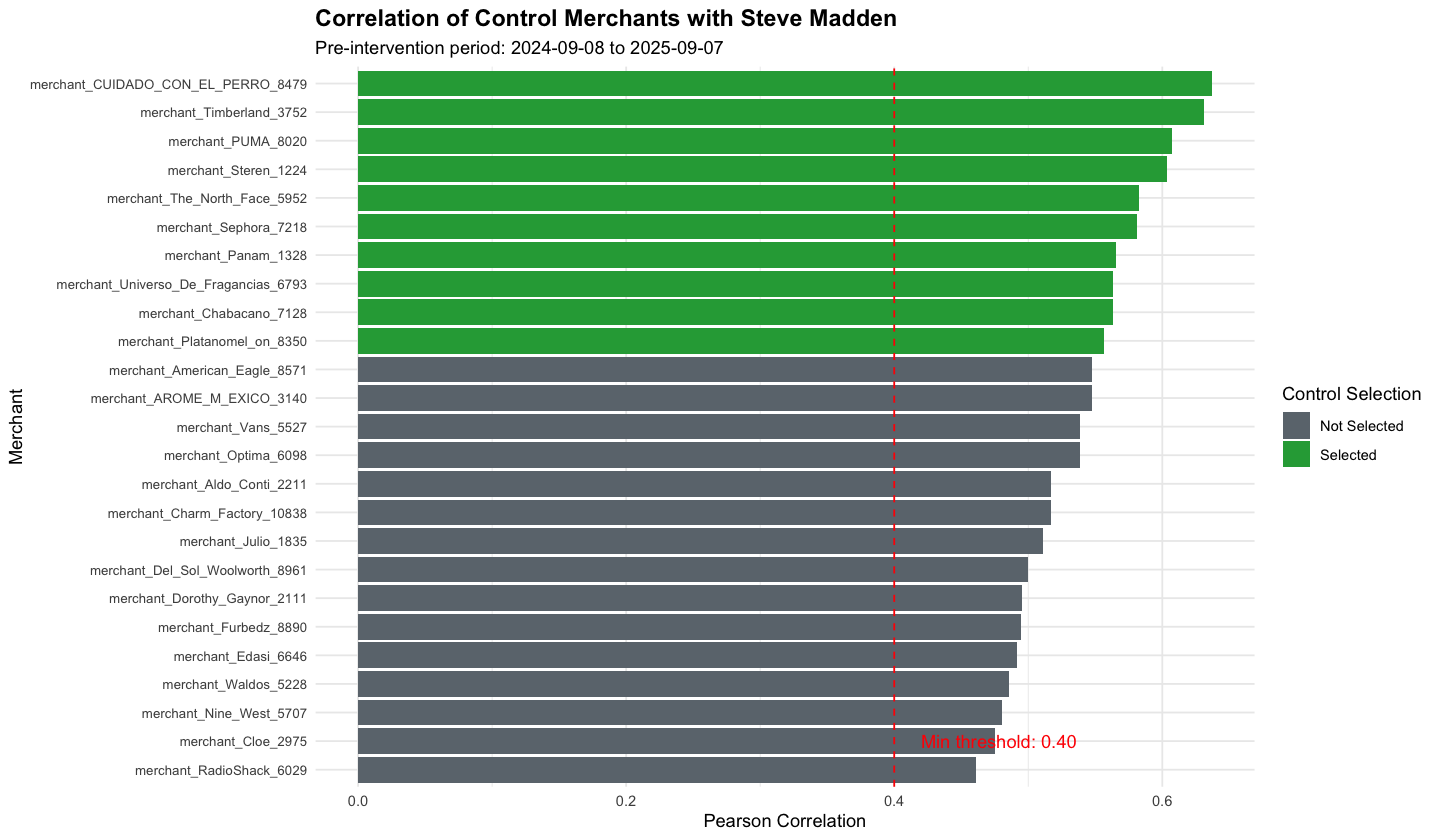

In [58]:
# Bar plot of top correlations
top_corr <- head(correlation_df, 25)

options(repr.plot.width = 12, repr.plot.height = 7)

ggplot(top_corr, aes(x = reorder(merchant, correlation), y = correlation, 
                      fill = selected)) +
  geom_col() +
  geom_hline(yintercept = MIN_CORRELATION, linetype = "dashed", color = "red") +
  coord_flip() +
  scale_fill_manual(values = c("TRUE" = "#28a745", "FALSE" = "#6c757d"),
                    labels = c("TRUE" = "Selected", "FALSE" = "Not Selected")) +
  labs(
    title = "Correlation of Control Merchants with Steve Madden",
    subtitle = sprintf("Pre-intervention period: %s to %s", DATA_START, INTERVENTION_START - 1),
    x = "Merchant",
    y = "Pearson Correlation",
    fill = "Control Selection"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 8)
  ) +
  annotate("text", x = 2, y = MIN_CORRELATION + 0.02, 
           label = sprintf("Min threshold: %.2f", MIN_CORRELATION),
           color = "red", hjust = 0)

ggsave(file.path(OUTPUT_DIR, "control_correlation_barplot.png"), 
       width = 10, height = 6, dpi = 150)


## 3.3 Select Final Controls


In [59]:
# Get selected control merchants
selected_controls <- correlation_df %>%
  filter(selected) %>%
  pull(merchant)

cat(sprintf("\nSelected %d control merchants with correlation >= %.2f\n",
            length(selected_controls), MIN_CORRELATION))
cat("\nSelected merchants:\n")
cat(paste(selected_controls, collapse = "\n"))

# Create final analysis dataset with selected controls only
final_data <- analysis_data %>%
  select(loan_request_date_local, steve_madden, all_of(selected_controls))

# Save control selection
write.csv(correlation_df, 
          file.path(OUTPUT_DIR, "merchant_correlations.csv"), 
          row.names = FALSE)

cat(sprintf("\n\nFinal dataset: %d days x %d variables\n", 
            nrow(final_data), ncol(final_data)))



Selected 10 control merchants with correlation >= 0.40

Selected merchants:
merchant_CUIDADO_CON_EL_PERRO_8479
merchant_Timberland_3752
merchant_PUMA_8020
merchant_Steren_1224
merchant_The_North_Face_5952
merchant_Sephora_7218
merchant_Panam_1328
merchant_Universo_De_Fragancias_6793
merchant_Chabacano_7128
merchant_Platanomel_on_8350

Final dataset: 465 days x 12 variables


In [67]:
# ============================================================================
# ITERATIVE A/A TEST - Find best configuration (with MAPE optimization)
# ============================================================================
# This cell tests multiple combinations of:
#   - Number of top controls (5, 10, 15, 20, 25, 30)
#   - Minimum correlation thresholds (0.2, 0.3, 0.4, 0.5, 0.6)
# And finds which configuration:
#   1. Passes the A/A test (p-value > 0.05)
#   2. Has lowest MAPE (< 15% threshold)
# ============================================================================

# MAPE calculation function
calc_mape <- function(actual, predicted) {
  valid_idx <- actual != 0 & !is.na(actual) & !is.na(predicted)
  if (sum(valid_idx) == 0) return(NA)
  mean(abs(actual[valid_idx] - predicted[valid_idx]) / abs(actual[valid_idx]))
}

cat("Starting iterative A/A test search with MAPE optimization...\n")
cat("This may take 5-10 minutes.\n\n")

# Define expanded parameter grid for better optimization
n_controls_options <- c(5, 10, 15, 20, 25, 30)
min_corr_options <- c(0.2, 0.3, 0.4, 0.5, 0.6)

# Store results
aa_results <- data.frame()

# Get valid correlations (exclude NA and merchants with no variance)
valid_correlations <- correlation_df %>%
  filter(!is.na(correlation) & is.finite(correlation) & correlation > 0)

for (n_ctrl in n_controls_options) {
  for (min_corr in min_corr_options) {
    
    # Select controls for this configuration
    selected <- valid_correlations %>%
      filter(correlation >= min_corr) %>%
      head(n_ctrl) %>%
      pull(merchant)
    
    # Skip if not enough controls
    if (length(selected) < 3) {
      next
    }
    
    # Build dataset for this configuration
    test_data <- analysis_data %>%
      select(loan_request_date_local, steve_madden, all_of(selected))
    
    # Filter for A/A test period
    aa_test_data <- test_data %>%
      filter(loan_request_date_local >= AA_TEST_START &
             loan_request_date_local <= AA_TEST_END)
    
    # Skip if not enough data
    if (nrow(aa_test_data) < 30) {
      next
    }
    
    # Run A/A test
    tryCatch({
      aa_ts_test <- zoo(
        aa_test_data[, -1],
        order.by = aa_test_data$loan_request_date_local
      )
      
      aa_pre <- as.Date(c(AA_TEST_START, AA_PSEUDO_INTERVENTION - 1))
      aa_post <- as.Date(c(AA_PSEUDO_INTERVENTION, AA_TEST_END))
      
      # Run CausalImpact with fewer iterations for speed
      aa_result <- CausalImpact(
        data = aa_ts_test,
        pre.period = aa_pre,
        post.period = aa_post,
        model.args = list(niter = 500, nseasons = 7)
      )
      
      p_value <- aa_result$summary$p[1]
      abs_effect <- aa_result$summary$AbsEffect[2]
      
      # Calculate MAPE on post-period
      post_series <- aa_result$series[index(aa_result$series) >= AA_PSEUDO_INTERVENTION, ]
      actual_vals <- as.numeric(post_series[, "response"])
      predicted_vals <- as.numeric(post_series[, "point.pred"])
      mape_value <- calc_mape(actual_vals, predicted_vals)
      
      # Store result with MAPE
      aa_results <- rbind(aa_results, data.frame(
        n_controls = n_ctrl,
        min_correlation = min_corr,
        actual_controls = length(selected),
        p_value = round(p_value, 4),
        mape_pct = round(mape_value * 100, 2),
        cumulative_effect = round(abs_effect, 2),
        passed_aa = p_value > 0.05,
        passed_mape = mape_value <= MAPE_THRESHOLD,
        passed_both = (p_value > 0.05) & (mape_value <= MAPE_THRESHOLD)
      ))
      
      status <- case_when(
        p_value > 0.05 & mape_value <= MAPE_THRESHOLD ~ "✓✓ BOTH OK",
        p_value > 0.05 ~ "✓ AA ok, MAPE high",
        mape_value <= MAPE_THRESHOLD ~ "✗ AA fail, MAPE ok",
        TRUE ~ "✗✗ BOTH FAIL"
      )
      
      cat(sprintf("n=%2d, corr>=%.1f: p=%.3f, MAPE=%.1f%% %s\n", 
                  n_ctrl, min_corr, p_value, mape_value * 100, status))
      
    }, error = function(e) {
      cat(sprintf("n=%d, corr>=%.1f: ERROR - %s\n", n_ctrl, min_corr, e$message))
    })
  }
}

# Show summary
cat("\n========================================\n")
cat("A/A TEST RESULTS SUMMARY (with MAPE)\n")
cat("========================================\n")
cat(sprintf("MAPE threshold: %.0f%%\n\n", MAPE_THRESHOLD * 100))

if (nrow(aa_results) > 0) {
  # Sort by: passed_both first, then lowest MAPE
  aa_results <- aa_results %>% 
    arrange(desc(passed_both), mape_pct, desc(p_value))
  
  print(aa_results)
  
  # Show best configuration that passes BOTH criteria
  passed_both <- aa_results %>% filter(passed_both)
  passed_aa_only <- aa_results %>% filter(passed_aa & !passed_mape)
  
  if (nrow(passed_both) > 0) {
    best <- passed_both[1, ]
    cat("\n✅✅ BEST CONFIGURATION (passes A/A test AND MAPE threshold):\n")
    cat(sprintf("   TOP_N_CONTROLS = %d\n", best$n_controls))
    cat(sprintf("   MIN_CORRELATION = %.1f\n", best$min_correlation))
    cat(sprintf("   P-value = %.4f (no spurious effect)\n", best$p_value))
    cat(sprintf("   MAPE = %.2f%% (below %.0f%% threshold)\n", best$mape_pct, MAPE_THRESHOLD * 100))
    cat("\n🎯 Update these values in the configuration cell and re-run from section 3.\n")
    
  } else if (nrow(passed_aa_only) > 0) {
    # Show best A/A passing config even if MAPE is high
    best_aa <- passed_aa_only %>% arrange(mape_pct) %>% head(1)
    cat("\n⚠️ NO CONFIG PASSES BOTH CRITERIA\n")
    cat("\nBest A/A passing config (lowest MAPE):\n")
    cat(sprintf("   TOP_N_CONTROLS = %d\n", best_aa$n_controls))
    cat(sprintf("   MIN_CORRELATION = %.1f\n", best_aa$min_correlation))
    cat(sprintf("   P-value = %.4f ✓\n", best_aa$p_value))
    cat(sprintf("   MAPE = %.2f%% (above threshold, but best available)\n", best_aa$mape_pct))
    cat("\nOptions to improve MAPE:\n")
    cat("  1. Increase A/A test period length\n")
    cat("  2. Try different niter values (1000, 2000, 5000)\n")
    cat("  3. Consider if current MAPE is acceptable for your use case\n")
    
  } else {
    cat("\n❌ NO CONFIGURATION PASSED THE A/A TEST\n")
    cat("Consider:\n")
    cat("  - Using a different A/A test period\n")
    cat("  - Checking for data quality issues\n")
    cat("  - Increasing model iterations (niter)\n")
  }
} else {
  cat("No valid configurations tested.\n")
}

# Save results
write.csv(aa_results, file.path(OUTPUT_DIR, "aa_test_iterations.csv"), row.names = FALSE)
cat(sprintf("\nResults saved to: %s\n", file.path(OUTPUT_DIR, "aa_test_iterations.csv")))


Starting iterative A/A test search with MAPE optimization...
This may take 5-10 minutes.



Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n= 5, corr>=0.2: p=0.154, MAPE=23.7% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n= 5, corr>=0.3: p=0.184, MAPE=23.7% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n= 5, corr>=0.4: p=0.166, MAPE=23.7% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n= 5, corr>=0.5: p=0.178, MAPE=23.7% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n= 5, corr>=0.6: p=0.164, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=10, corr>=0.2: p=0.180, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=10, corr>=0.3: p=0.211, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=10, corr>=0.4: p=0.211, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=10, corr>=0.5: p=0.207, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=10, corr>=0.6: p=0.200, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=15, corr>=0.2: p=0.173, MAPE=22.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=15, corr>=0.3: p=0.182, MAPE=22.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=15, corr>=0.4: p=0.169, MAPE=22.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=15, corr>=0.5: p=0.177, MAPE=22.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=15, corr>=0.6: p=0.192, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=20, corr>=0.2: p=0.176, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=20, corr>=0.3: p=0.196, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=20, corr>=0.4: p=0.200, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=20, corr>=0.5: p=0.199, MAPE=23.4% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=20, corr>=0.6: p=0.166, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=25, corr>=0.2: p=0.197, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=25, corr>=0.3: p=0.183, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=25, corr>=0.4: p=0.209, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=25, corr>=0.5: p=0.187, MAPE=23.4% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=25, corr>=0.6: p=0.190, MAPE=23.6% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=30, corr>=0.2: p=0.198, MAPE=23.5% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=30, corr>=0.3: p=0.221, MAPE=23.5% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=30, corr>=0.4: p=0.213, MAPE=23.5% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=30, corr>=0.5: p=0.181, MAPE=23.4% <U+2713> AA ok, MAPE high


Warning message in FormatInputForConstructModel(data, model.args):
"Results potentially inaccurate. Consider using more MCMC samples."


n=30, corr>=0.6: p=0.182, MAPE=23.6% <U+2713> AA ok, MAPE high

A/A TEST RESULTS SUMMARY (with MAPE)
MAPE threshold: 15%

   n_controls min_correlation actual_controls p_value mape_pct
1          15             0.3              15  0.1818    22.59
2          15             0.5              15  0.1775    22.59
3          15             0.2              15  0.1732    22.59
4          15             0.4              15  0.1688    22.59
5          20             0.5              17  0.1988    23.41
6          25             0.5              17  0.1867    23.41
7          30             0.5              17  0.1807    23.41
8          30             0.3              30  0.2209    23.55
9          30             0.4              30  0.2127    23.55
10         30             0.2              30  0.1984    23.55
11         25             0.4              25  0.2093    23.59
12         20             0.4              20  0.2000    23.59
13         25             0.2              25  0.1972    23

# 4. A/A Test Validation

Before running the main analysis, we validate the model using an A/A test on a period with no intervention. If the model detects a significant effect, it indicates potential issues with model fit or biases.

## 4.1 A/A Test Setup


In [60]:
# Filter data for A/A test period
aa_data <- final_data %>%
  filter(loan_request_date_local >= AA_TEST_START &
         loan_request_date_local <= AA_TEST_END)

cat(sprintf("A/A Test Period: %s to %s\n", AA_TEST_START, AA_TEST_END))
cat(sprintf("Pseudo-intervention date: %s\n", AA_PSEUDO_INTERVENTION))
cat(sprintf("Pre-period: %d days\n", 
            sum(aa_data$loan_request_date_local < AA_PSEUDO_INTERVENTION)))
cat(sprintf("Post-period: %d days\n", 
            sum(aa_data$loan_request_date_local >= AA_PSEUDO_INTERVENTION)))


A/A Test Period: 2025-06-01 to 2025-08-01
Pseudo-intervention date: 2025-07-01
Pre-period: 30 days
Post-period: 32 days


## 4.2 Run A/A Test


In [61]:
# Prepare time series for CausalImpact
aa_ts <- zoo(
  aa_data[, -1],  # Exclude date column
  order.by = aa_data$loan_request_date_local
)

# Define periods for A/A test
aa_pre_period <- as.Date(c(AA_TEST_START, AA_PSEUDO_INTERVENTION - 1))
aa_post_period <- as.Date(c(AA_PSEUDO_INTERVENTION, AA_TEST_END))

# Run CausalImpact with A/A test
cat("Running A/A Test CausalImpact model...\n")
aa_impact <- CausalImpact(
  data = aa_ts,
  pre.period = aa_pre_period,
  post.period = aa_post_period,
  model.args = MODEL_PARAMS
)

# Extract summary
cat("\nA/A Test Summary:\n")
print(summary(aa_impact))


Running A/A Test CausalImpact model...

A/A Test Summary:
Posterior inference {CausalImpact}

                         Average        Cumulative    
Actual                   39             1260          
Prediction (s.d.)        37 (2.7)       1185 (87.2)   
95% CI                   [32, 42]       [1008, 1349]  
                                                      
Absolute effect (s.d.)   2.4 (2.7)      75.4 (87.2)   
95% CI                   [-2.8, 7.9]    [-88.6, 251.6]
                                                      
Relative effect (s.d.)   7.1% (8.2%)    7.1% (8.2%)   
95% CI                   [-6.6%, 25%]   [-6.6%, 25%]  

Posterior tail-area probability p:   0.18488
Posterior probability of an effect:  82%

For more details, type: summary(impact, "report")

NULL


## 4.3 A/A Test Results Visualization


Warning message in scale_x_date():
"A <numeric> value was passed to a Date scale.
i The value was converted to a <Date> object."
Warning message in scale_x_date():
"A <numeric> value was passed to a Date scale.
i The value was converted to a <Date> object."


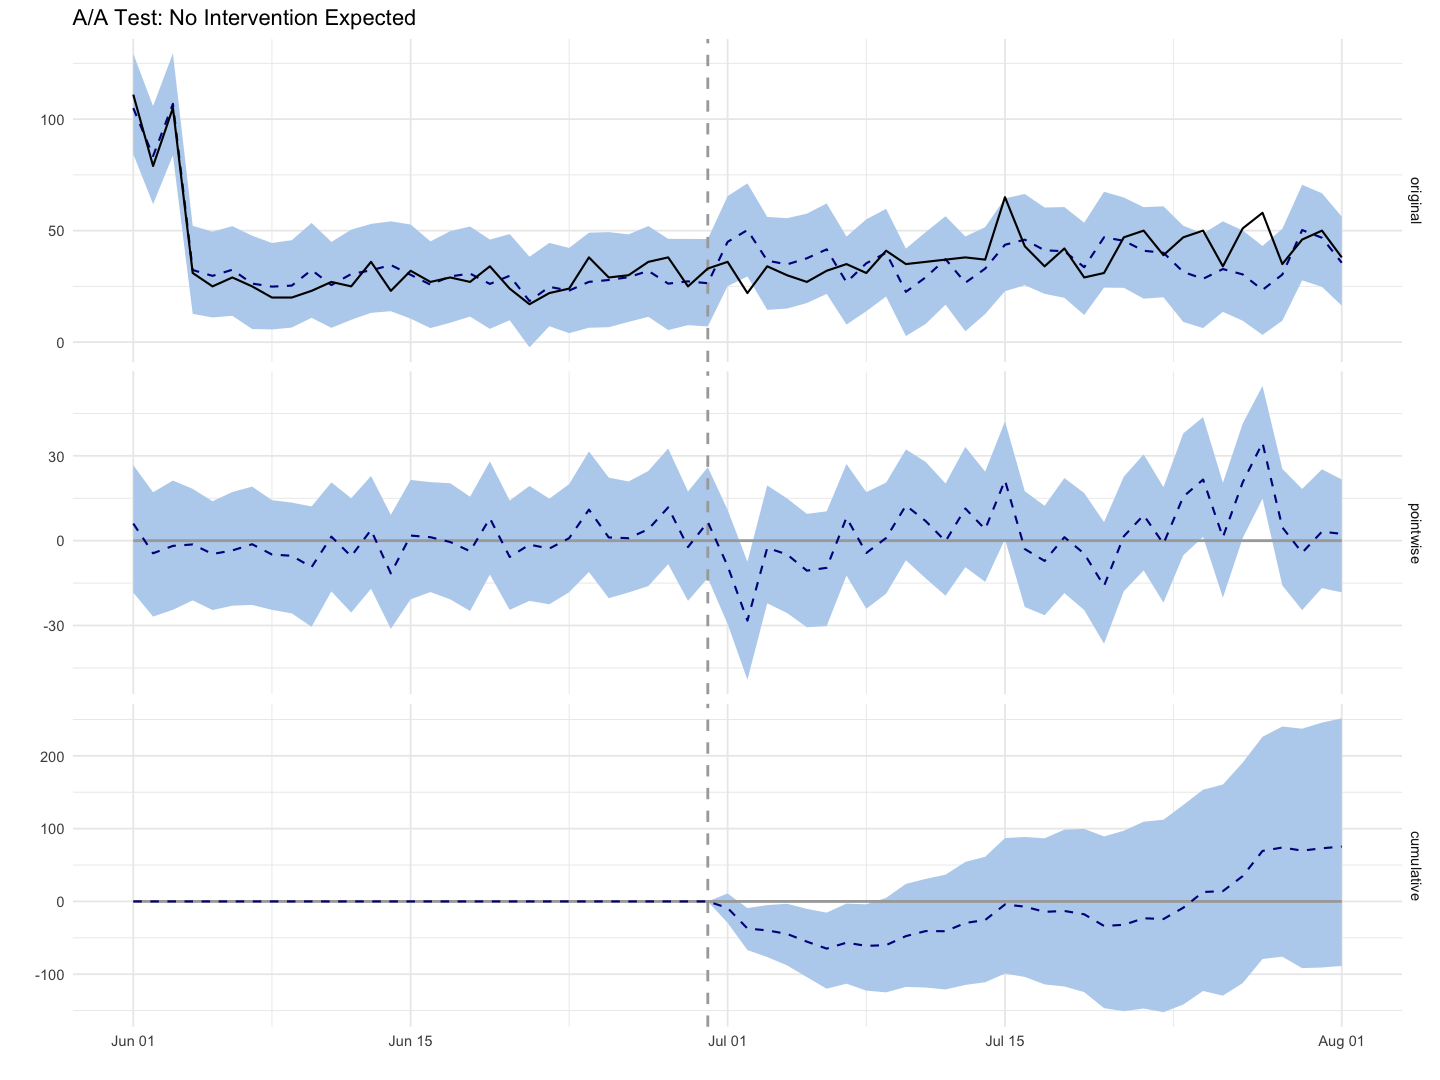

In [62]:
options(repr.plot.width = 12, repr.plot.height = 9)

# Plot A/A test results
plot(aa_impact) +
  ggtitle("A/A Test: No Intervention Expected") +
  theme_minimal()

ggsave(file.path(OUTPUT_DIR, "aa_test_results.png"), 
       width = 12, height = 8, dpi = 150)


## 4.4 A/A Test Validation Check


In [63]:
# Check if A/A test passed
aa_pvalue <- aa_impact$summary$p[1]

cat("\n========================================\n")
cat("A/A TEST VALIDATION RESULTS\n")
cat("========================================\n")
cat(sprintf("P-value: %.4f\n", aa_pvalue))

if (aa_pvalue > AA_P_VALUE_THRESHOLD) {
  cat("RESULT: PASSED - No spurious effect detected\n")
  cat("The model is suitable for the main analysis.\n")
  aa_test_passed <- TRUE
} else {
  cat("RESULT: WARNING - Spurious effect detected!\n")
  cat("Consider reviewing control selection or model parameters.\n")
  aa_test_passed <- FALSE
}



A/A TEST VALIDATION RESULTS
P-value: 0.1849
RESULT: PASSED - No spurious effect detected
The model is suitable for the main analysis.


## 4.5 Calculate Weighted MAPE


In [64]:
# Calculate Weighted MAPE function
calculate_weighted_mape <- function(actual, predicted, weights = NULL) {
  if (is.null(weights)) {
    weights <- rep(1, length(actual))
  }
  
  # Avoid division by zero
  valid_idx <- actual != 0
  
  if (sum(valid_idx) == 0) {
    return(NA)
  }
  
  ape <- abs(actual[valid_idx] - predicted[valid_idx]) / abs(actual[valid_idx])
  w <- weights[valid_idx]
  
  weighted_mape <- sum(ape * w) / sum(w)
  return(weighted_mape)
}

# Calculate MAPE on A/A test post-period
aa_post_data <- aa_impact$series[index(aa_impact$series) >= AA_PSEUDO_INTERVENTION, ]
aa_actual <- as.numeric(aa_post_data[, "response"])
aa_predicted <- as.numeric(aa_post_data[, "point.pred"])

aa_mape <- calculate_weighted_mape(aa_actual, aa_predicted)

cat(sprintf("\nWeighted MAPE on A/A Test: %.2f%%\n", aa_mape * 100))

if (aa_mape <= MAPE_THRESHOLD) {
  cat(sprintf("RESULT: PASSED - MAPE (%.2f%%) is below threshold (%.2f%%)\n", 
              aa_mape * 100, MAPE_THRESHOLD * 100))
  mape_passed <- TRUE
} else {
  cat(sprintf("RESULT: WARNING - MAPE (%.2f%%) exceeds threshold (%.2f%%)\n", 
              aa_mape * 100, MAPE_THRESHOLD * 100))
  cat("Consider adjusting model parameters or control selection.\n")
  mape_passed <- FALSE
}



Weighted MAPE on A/A Test: 23.52%
RESULT: WARNING - MAPE (23.52%) exceeds threshold (15.00%)
Consider adjusting model parameters or control selection.


# 5. CausalImpact Analysis (Main)

## 5.1 Define Analysis Periods


In [80]:
# Pre-period: from data start to day before intervention
pre_period <- as.Date(c(DATA_START, INTERVENTION_START - 1))

# Post-period: intervention period
post_period <- as.Date(c(INTERVENTION_START, INTERVENTION_END))

cat("Analysis Periods:\n")
cat(sprintf("  Pre-period:  %s to %s (%d days)\n", 
            pre_period[1], pre_period[2],
            as.numeric(pre_period[2] - pre_period[1]) + 1))
cat(sprintf("  Post-period: %s to %s (%d days)\n", 
            post_period[1], post_period[2],
            as.numeric(post_period[2] - post_period[1]) + 1))


Analysis Periods:
  Pre-period:  2025-06-15 to 2025-09-07 (85 days)
  Post-period: 2025-09-08 to 2025-11-18 (72 days)


## 5.2 Prepare Data for Model


In [81]:
# Filter data to analysis period
model_data <- final_data %>%
  filter(loan_request_date_local >= pre_period[1] &
         loan_request_date_local <= post_period[2])

# Convert to zoo time series
model_ts <- zoo(
  model_data[, -1],  # Exclude date column
  order.by = model_data$loan_request_date_local
)

cat(sprintf("\nModel data prepared: %d observations\n", nrow(model_data)))
cat(sprintf("Treatment variable: steve_madden\n"))
cat(sprintf("Control variables: %d merchants\n", ncol(model_data) - 2))
cat(sprintf("\nPre-period: %d days\n", sum(model_data$loan_request_date_local < INTERVENTION_START)))
cat(sprintf("Post-period: %d days\n", sum(model_data$loan_request_date_local >= INTERVENTION_START)))



Model data prepared: 157 observations
Treatment variable: steve_madden
Control variables: 10 merchants

Pre-period: 85 days
Post-period: 72 days


## 5.3 Run CausalImpact Model


In [82]:
# Run the main CausalImpact analysis
cat("Running main CausalImpact model...\n")
cat(sprintf("Parameters: niter=%d, nseasons=%d\n", 
            MODEL_PARAMS$niter, MODEL_PARAMS$nseasons))

impact <- CausalImpact(
  data = model_ts,
  pre.period = pre_period,
  post.period = post_period,
  model.args = MODEL_PARAMS
)

# Print summary
cat("\n========================================\n")
cat("CAUSALIMPACT MODEL RESULTS\n")
cat("========================================\n")
print(summary(impact))


Running main CausalImpact model...
Parameters: niter=10000, nseasons=7



CAUSALIMPACT MODEL RESULTS
Posterior inference {CausalImpact}

                         Average        Cumulative    
Actual                   34             2414          
Prediction (s.d.)        35 (1.5)       2533 (110.2)  
95% CI                   [32, 38]       [2319, 2749]  
                                                      
Absolute effect (s.d.)   -1.7 (1.5)     -119.5 (110.2)
95% CI                   [-4.7, 1.3]    [-335.3, 94.8]
                                                      
Relative effect (s.d.)   -4.5% (4.2%)   -4.5% (4.2%)  
95% CI                   [-12%, 4.1%]   [-12%, 4.1%]  

Posterior tail-area probability p:   0.13648
Posterior probability of an effect:  86%

For more details, type: summary(impact, "report")

NULL


## 5.4 Model Diagnostics


In [83]:
# Calculate MAPE on post-period
post_data <- impact$series[index(impact$series) >= INTERVENTION_START, ]
actual <- as.numeric(post_data[, "response"])
predicted <- as.numeric(post_data[, "point.pred"])

model_mape <- calculate_weighted_mape(actual, predicted)

# Extract key metrics
impact_summary <- impact$summary

diagnostics <- data.frame(
  Metric = c(
    "Average Daily Effect",
    "Cumulative Effect",
    "Relative Effect (%)",
    "P-value",
    "Posterior Probability of Effect",
    "95% CI Lower (Cumulative)",
    "95% CI Upper (Cumulative)",
    "Post-Period MAPE (%)"
  ),
  Value = c(
    round(impact_summary$AbsEffect[1], 2),
    round(impact_summary$AbsEffect[2], 2),
    round(impact_summary$RelEffect[2] * 100, 2),
    round(impact_summary$p[1], 4),
    round(1 - impact_summary$p[1], 4),
    round(impact_summary$AbsEffect.lower[2], 2),
    round(impact_summary$AbsEffect.upper[2], 2),
    round(model_mape * 100, 2)
  )
)

cat("Model Diagnostics and Key Results:\n")
print(diagnostics)

# Save diagnostics
write.csv(diagnostics, 
          file.path(OUTPUT_DIR, "model_diagnostics.csv"), 
          row.names = FALSE)
cat(sprintf("\nDiagnostics saved to: %s\n", file.path(OUTPUT_DIR, "model_diagnostics.csv")))


Model Diagnostics and Key Results:
                           Metric     Value
1            Average Daily Effect   -1.6600
2               Cumulative Effect -119.4600
3             Relative Effect (%)   -4.5300
4                         P-value    0.1365
5 Posterior Probability of Effect    0.8635
6       95% CI Lower (Cumulative) -335.3400
7       95% CI Upper (Cumulative)   94.8000
8            Post-Period MAPE (%)   33.8800

Diagnostics saved to: outputs/model_diagnostics.csv


# 6. Results and Visualizations

## 6.1 Main CausalImpact Plot


Warning message in scale_x_date():
"A <numeric> value was passed to a Date scale.
i The value was converted to a <Date> object."
Warning message in scale_x_date():
"A <numeric> value was passed to a Date scale.
i The value was converted to a <Date> object."


Plot saved to: outputs/causal_impact_summary.png

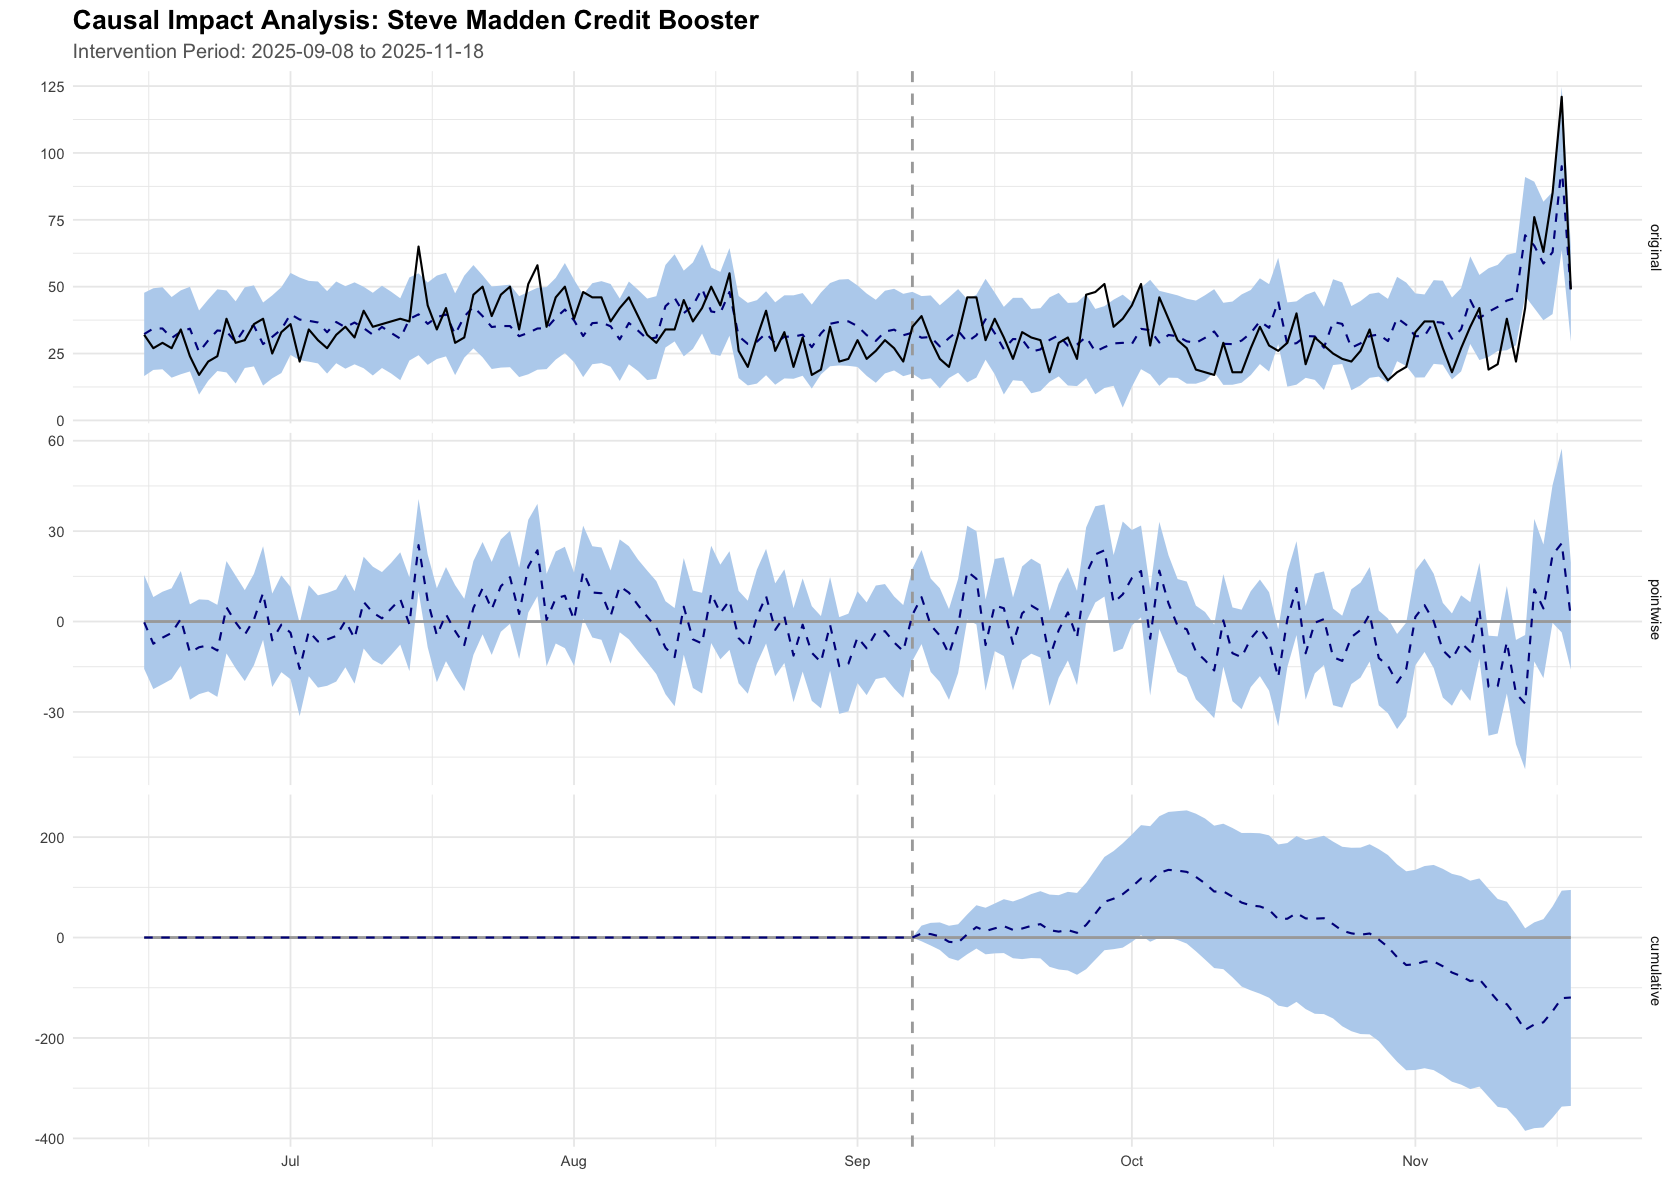

In [84]:
options(repr.plot.width = 14, repr.plot.height = 10)

# Create the main CausalImpact visualization
plot(impact) +
  labs(
    title = "Causal Impact Analysis: Steve Madden Credit Booster",
    subtitle = sprintf("Intervention Period: %s to %s", 
                       INTERVENTION_START, INTERVENTION_END)
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12, color = "gray40")
  )

ggsave(file.path(OUTPUT_DIR, "causal_impact_summary.png"), 
       width = 14, height = 10, dpi = 150)
cat("Plot saved to:", file.path(OUTPUT_DIR, "causal_impact_summary.png"))


## 6.2 Daily Effects Analysis


In [86]:
# Extract daily effects
daily_effects <- data.frame(
  date = index(impact$series),
  actual = as.numeric(impact$series[, "response"]),
  predicted = as.numeric(impact$series[, "point.pred"]),
  effect = as.numeric(impact$series[, "point.effect"]),
  effect_lower = as.numeric(impact$series[, "point.effect.lower"]),
  effect_upper = as.numeric(impact$series[, "point.effect.upper"]),
  cumulative = as.numeric(impact$series[, "cum.effect"]),
  cumulative_lower = as.numeric(impact$series[, "cum.effect.lower"]),
  cumulative_upper = as.numeric(impact$series[, "cum.effect.upper"])
) %>%
  mutate(
    period = ifelse(date < INTERVENTION_START, "Pre-Intervention", "Post-Intervention")
  )

# Filter to post-intervention period for effects table
post_effects <- daily_effects %>%
  filter(period == "Post-Intervention")

# Summary statistics
cat("\n========================================\n")
cat("DAILY EFFECTS SUMMARY (Post-Intervention)\n")
cat("========================================\n")
cat(sprintf("Average daily actual loans: %.1f\n", mean(post_effects$actual)))
cat(sprintf("Average daily predicted (counterfactual): %.1f\n", mean(post_effects$predicted)))
cat(sprintf("Average daily effect: %.1f loans\n", mean(post_effects$effect)))
cat(sprintf("Total days in intervention: %d\n", nrow(post_effects)))
cat(sprintf("Cumulative effect: %.0f loans\n", tail(post_effects$cumulative, 1)))

# Save daily effects
write.csv(daily_effects, 
          file.path(OUTPUT_DIR, "daily_effects.csv"), 
          row.names = FALSE)

# Display last 10 days
cat("\nLast 10 Days of Post-Intervention Effects:\n")
tail(post_effects[, c("date", "actual", "predicted", "effect", "cumulative")], 72)



DAILY EFFECTS SUMMARY (Post-Intervention)
Average daily actual loans: 33.5
Average daily predicted (counterfactual): 35.2
Average daily effect: -1.7 loans
Total days in intervention: 72
Cumulative effect: -119 loans

Last 10 Days of Post-Intervention Effects:


,date,actual,predicted,effect,cumulative
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,2025-09-08,39,30.91462,8.085376,8.085376
2,2025-09-09,30,31.19571,-1.195713,6.889663
3,2025-09-10,23,27.66080,-4.660800,2.228863
4,2025-09-11,20,30.79169,-10.791693,-8.562830
5,2025-09-12,32,33.50770,-1.507703,-10.070533
6,2025-09-13,46,29.38579,16.614215,6.543681
7,2025-09-14,46,31.81025,14.189755,20.733436
8,2025-09-15,30,37.79745,-7.797449,12.935988
9,2025-09-16,38,32.65159,5.348407,18.284394


## 6.3 Actual vs Counterfactual Visualization


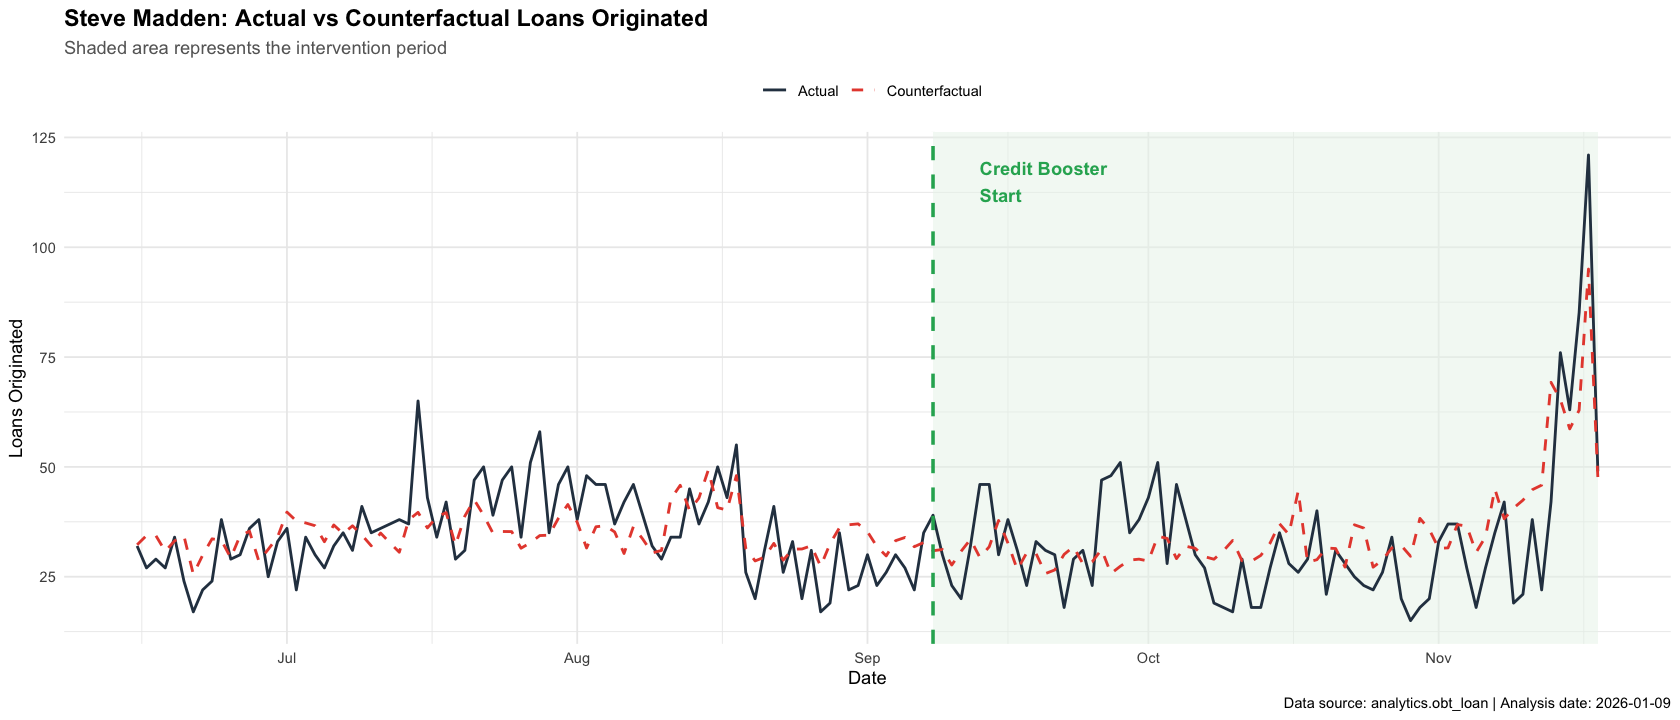

In [87]:
options(repr.plot.width = 14, repr.plot.height = 6)

ggplot(daily_effects, aes(x = date)) +
  # Intervention period shading
  annotate("rect", 
           xmin = INTERVENTION_START, xmax = INTERVENTION_END,
           ymin = -Inf, ymax = Inf,
           fill = "#e8f4ea", alpha = 0.5) +
  # Actual values
  geom_line(aes(y = actual, color = "Actual"), linewidth = 0.8) +
  # Predicted counterfactual
  geom_line(aes(y = predicted, color = "Counterfactual"), 
            linewidth = 0.8, linetype = "dashed") +
  # Styling
  scale_color_manual(
    values = c("Actual" = "#2c3e50", "Counterfactual" = "#e74c3c"),
    name = ""
  ) +
  geom_vline(xintercept = INTERVENTION_START, linetype = "dashed", 
             color = "#27ae60", linewidth = 1) +
  annotate("text", x = INTERVENTION_START + 5, y = max(daily_effects$actual, na.rm = TRUE) * 0.95,
           label = "Credit Booster\nStart", hjust = 0, color = "#27ae60", fontface = "bold") +
  labs(
    title = sprintf("Steve Madden: Actual vs Counterfactual %s", 
                    tools::toTitleCase(gsub("_", " ", METRIC))),
    subtitle = "Shaded area represents the intervention period",
    x = "Date",
    y = tools::toTitleCase(gsub("_", " ", METRIC)),
    caption = sprintf("Data source: analytics.obt_loan | Analysis date: %s", Sys.Date())
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 11, color = "gray40"),
    legend.position = "top"
  )

ggsave(file.path(OUTPUT_DIR, "actual_vs_counterfactual.png"), 
       width = 14, height = 6, dpi = 150)


## 6.4 Cumulative Effect Over Time


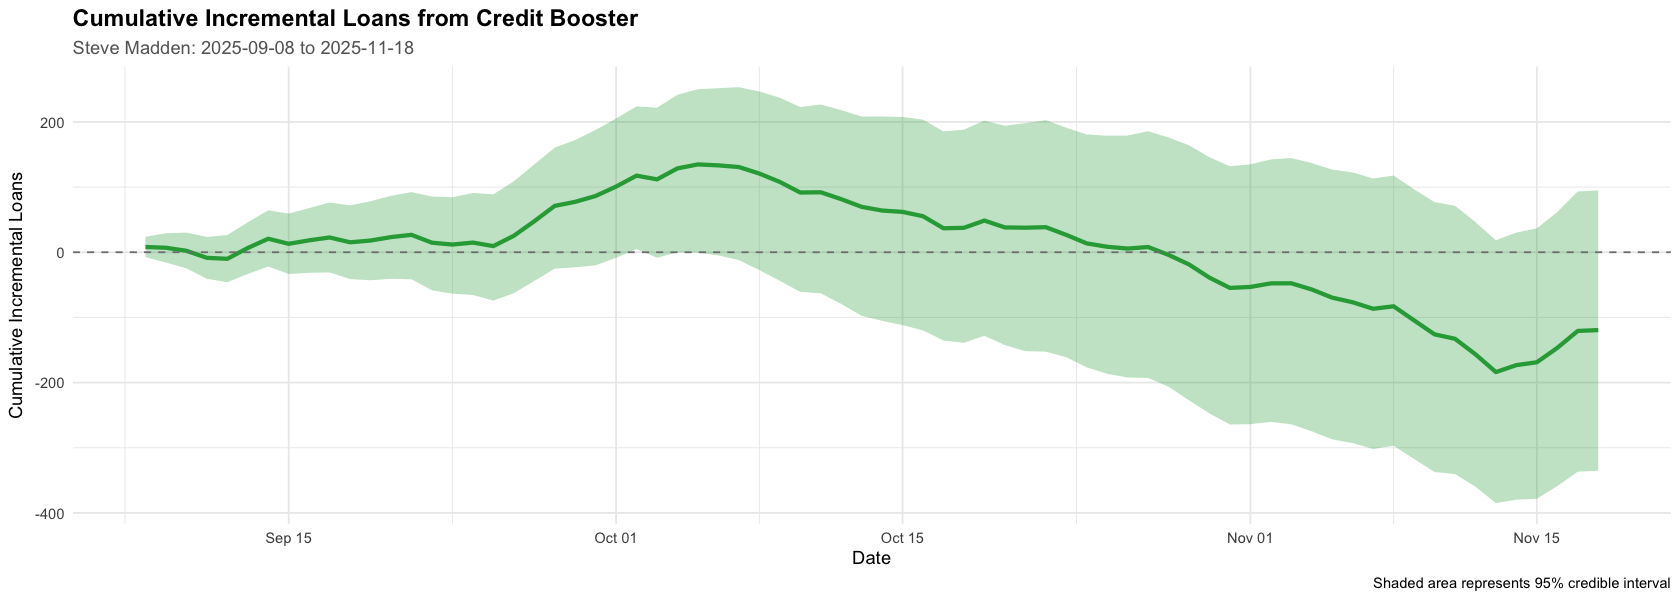

In [88]:
options(repr.plot.width = 14, repr.plot.height = 5)

# Plot cumulative effect during intervention
ggplot(post_effects, aes(x = date)) +
  geom_ribbon(aes(ymin = cumulative_lower, ymax = cumulative_upper),
              fill = "#28a745", alpha = 0.3) +
  geom_line(aes(y = cumulative), color = "#28a745", linewidth = 1.2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
  labs(
    title = "Cumulative Incremental Loans from Credit Booster",
    subtitle = sprintf("Steve Madden: %s to %s", INTERVENTION_START, INTERVENTION_END),
    x = "Date",
    y = "Cumulative Incremental Loans",
    caption = "Shaded area represents 95% credible interval"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 11, color = "gray40")
  ) +
  scale_y_continuous(labels = scales::comma)

ggsave(file.path(OUTPUT_DIR, "cumulative_effect.png"), 
       width = 14, height = 5, dpi = 150)


# 7. Summary Report


In [89]:
# Generate final summary
cat("\n")
cat("================================================================================\n")
cat("          CAUSAL IMPACT ANALYSIS: STEVE MADDEN CREDIT BOOSTER                  \n")
cat("                           FINAL SUMMARY REPORT                                 \n")
cat("================================================================================\n")
cat("\n")
cat("TREATMENT: Steve Madden Credit Booster ($1,000 increase)\n")
cat(sprintf("INTERVENTION PERIOD: %s to %s (%d days)\n", 
            INTERVENTION_START, INTERVENTION_END,
            as.numeric(INTERVENTION_END - INTERVENTION_START) + 1))
cat("\n")
cat("--------------------------------------------------------------------------------\n")
cat("MODEL VALIDATION:\n")
cat("--------------------------------------------------------------------------------\n")
cat(sprintf("  A/A Test:        %s (p-value: %.4f)\n", 
            ifelse(aa_test_passed, "PASSED", "FAILED"), aa_pvalue))
cat(sprintf("  MAPE:            %.2f%% (threshold: %.0f%%)\n",
            aa_mape * 100, MAPE_THRESHOLD * 100))
cat(sprintf("  Controls used:   %d merchants\n", ncol(final_data) - 2))
cat("\n")
cat("--------------------------------------------------------------------------------\n")
cat("KEY FINDINGS:\n")
cat("--------------------------------------------------------------------------------\n")
cat(sprintf("  Average daily effect:     %.1f incremental loans\n", 
            impact_summary$AbsEffect[1]))
cat(sprintf("  Cumulative effect:        %.0f incremental loans\n", 
            impact_summary$AbsEffect[2]))
cat(sprintf("  Relative effect:          %.1f%% increase vs counterfactual\n", 
            impact_summary$RelEffect[2] * 100))
cat(sprintf("  95%% Credible Interval:   [%.0f, %.0f] loans\n",
            impact_summary$AbsEffect.lower[2], impact_summary$AbsEffect.upper[2]))
cat("\n")
cat("--------------------------------------------------------------------------------\n")
cat("STATISTICAL SIGNIFICANCE:\n")
cat("--------------------------------------------------------------------------------\n")
cat(sprintf("  P-value:                  %.4f\n", impact_summary$p[1]))
cat(sprintf("  Posterior probability:    %.1f%%\n", 
            (1 - impact_summary$p[1]) * 100))

cat("\n")
cat("--------------------------------------------------------------------------------\n")
cat("CONCLUSION:\n")
cat("--------------------------------------------------------------------------------\n")

if (impact_summary$p[1] < 0.05) {
  cat("  The credit booster had a STATISTICALLY SIGNIFICANT effect on the number\n")
  cat("  of originated loans at Steve Madden.\n")
  cat(sprintf("\n  The intervention generated approximately %.0f additional loans\n", 
              impact_summary$AbsEffect[2]))
  cat(sprintf("  (95%% CI: %.0f to %.0f) during the intervention period.\n",
              impact_summary$AbsEffect.lower[2], impact_summary$AbsEffect.upper[2]))
} else if (impact_summary$p[1] < 0.1) {
  cat("  The credit booster showed a MARGINALLY SIGNIFICANT effect (p < 0.10)\n")
  cat("  on the number of originated loans at Steve Madden.\n")
  cat(sprintf("\n  The estimated effect is %.0f additional loans, but this result\n", 
              impact_summary$AbsEffect[2]))
  cat("  should be interpreted with caution.\n")
} else {
  cat("  The credit booster did NOT show a statistically significant effect\n")
  cat("  on the number of originated loans at Steve Madden.\n")
  cat("\n  This could mean:\n")
  cat("    - The credit booster had no real effect\n")
  cat("    - The effect was too small to detect with this data\n")
  cat("    - External factors obscured the true effect\n")
}

cat("\n")
cat("================================================================================\n")
cat("                              END OF REPORT                                     \n")
cat("================================================================================\n")



          CAUSAL IMPACT ANALYSIS: STEVE MADDEN CREDIT BOOSTER                  
                           FINAL SUMMARY REPORT                                 

TREATMENT: Steve Madden Credit Booster ($1,000 increase)
INTERVENTION PERIOD: 2025-09-08 to 2025-11-18 (72 days)

--------------------------------------------------------------------------------
MODEL VALIDATION:
--------------------------------------------------------------------------------
  A/A Test:        PASSED (p-value: 0.1849)
  MAPE:            23.52% (threshold: 15%)
  Controls used:   10 merchants

--------------------------------------------------------------------------------
KEY FINDINGS:
--------------------------------------------------------------------------------
  Average daily effect:     -1.7 incremental loans
  Cumulative effect:        -119 incremental loans
  Relative effect:          -4.5% increase vs counterfactual
  95% Credible Interval:   [-335, 95] loans

---------------------------------------

## Full CausalImpact Narrative Report


In [90]:
# Print the full narrative report from CausalImpact package
cat("Full CausalImpact Narrative Report:\n")
cat("=====================================\n\n")
summary(impact, "report")


Full CausalImpact Narrative Report:

Analysis report {CausalImpact}


During the post-intervention period, the response variable had an average value of approx. 33.53. In the absence of an intervention, we would have expected an average response of 35.19. The 95% interval of this counterfactual prediction is [32.21, 38.19]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is -1.66 with a 95% interval of [-4.66, 1.32]. For a discussion of the significance of this effect, see below.

Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response variable had an overall value of 2.41K. Had the intervention not taken place, we would have expected a sum of 2.53K. The 95% interval of this prediction is [2.32K, 2.75K].

The above results are given in terms of absolute numbers. In relative terms, the response va

# 8. Session Info and Output Files


In [91]:
# List all output files generated
cat("Output files generated:\n")
cat("========================\n\n")

output_files <- list.files(OUTPUT_DIR, full.names = TRUE)
for (f in output_files) {
  file_info <- file.info(f)
  cat(sprintf("  %s (%.1f KB)\n", basename(f), file_info$size / 1024))
}

cat("\n\nSession Info:\n")
cat("=============\n")
sessionInfo()


Output files generated:

  aa_test_iterations.csv (1.5 KB)
  aa_test_results.png (221.8 KB)
  actual_vs_counterfactual.png (210.8 KB)
  causal_impact_summary.png (364.9 KB)
  control_correlation_barplot.png (154.8 KB)
  cumulative_effect.png (126.2 KB)
  daily_effects.csv (20.0 KB)
  merchant_correlations.csv (125.0 KB)
  model_diagnostics.csv (0.3 KB)
  raw_loan_data.rds (2498.9 KB)


Session Info:


R version 4.5.2 (2025-10-31)
Platform: aarch64-apple-darwin24.4.0
Running under: macOS Sequoia 15.5

Matrix products: default
BLAS:   /opt/homebrew/Cellar/openblas/0.3.30/lib/libopenblasp-r0.3.30.dylib 
LAPACK: /opt/homebrew/Cellar/r/4.5.2_1/lib/R/lib/libRlapack.dylib;  LAPACK version 3.12.1

locale:
[1] C

time zone: America/Mexico_City
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.4.0        corrplot_0.95       ggplot2_4.0.1      
 [4] lubridate_1.9.4     tidyr_1.3.1         dplyr_1.1.4        
 [7] DBI_1.2.3           bigrquery_1.6.1     CausalImpact_1.4.1 
[10] bsts_0.9.11         xts_0.14.1          zoo_1.8-15         
[13] BoomSpikeSlab_1.2.7 Boom_0.9.16        

loaded via a namespace (and not attached):
 [1] rappdirs_0.3.3     generics_0.1.4     lattice_0.22-7     digest_0.6.39     
 [5] magrittr_2.0.4     evaluate_1.0.5     grid_4.5.2         timechange_0.3.0  
